In [1]:
# load metafiles to have a clear overview of where each final genome came from
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import matplotlib.patches as patches
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import re
from os import listdir
from os.path import isfile, join

import HTSeq
from Bio import SeqIO

font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('lines',lw=2) 
sns.set(font_scale = 2)

In [2]:
import ast
def read_checkm_tsv(filedir):
    # read the checkm bin_stats_ext.tsv file (this has the other metadata like GC etc)
    metadata = list(open(filedir+'storage/bin_stats_ext.tsv'))
    metadata = [m.split('\n') for m in metadata]
    metadf = pd.DataFrame.from_records(metadata)
    metadf = metadf.drop(1,1)
    metadf.columns = ['bla']
    metadf = metadf['bla'].str.split('\t',1,expand=True)
    metadf = metadf.set_index(0)
    metadf.columns = ['metadata']

    columns = ['marker lineage','Completeness','Contamination','# contigs','Genome size','# genomes','# marker sets','# markers','# predicted genes','Coding density','GC','GC std','Longest contig','Mean contig length','N50 (contigs)']
    metadata_obs = pd.DataFrame(index=metadf.index,columns=columns)

    for d in metadf.index:
        dictionary = ast.literal_eval(metadf.loc[d,'metadata'])
        for j in metadata_obs.columns:
            metadata_obs.loc[d,j] = dictionary[j]
    checkm_metadata = metadata_obs.copy()
    #checkm_metadata.to_pickle(filedir+'metadata_pickle')
    return(checkm_metadata)

def make_checkm_output_df(filedir):
    # run the read_checkm_tsv and add the outputfile.txt
    meta = read_checkm_tsv(filedir)
    strhet = pd.read_table(filedir+'outputfile.txt')
    strhet = strhet.set_index('Bin Id')
    
    meta = meta.join(strhet['Strain heterogeneity'])
    meta = meta.sort_values('Completeness',ascending=False)
    return(meta)

# find the original bin index of the metadata file and replace 
def get_old_bin_names(meta_new,startidx,stopidx):
    # this assumes translation df exists 
    transl = pd.read_table('fasta/genome_bins_obsidian/info.table')
    
    meta_new['old_idx'] = '';meta_new['sample']=''
    for brian_name in meta_new.index:
        brian_idx = brian_name[startidx:stopidx]
        meta_new.loc[brian_name,'old_idx'] = transl[transl['NewName'].str[-3:]==brian_idx].set_index('Unnamed: 0').index[0]+'_'+brian_name[-1] #ds
        meta_new.loc[brian_name,'sample'] = transl[transl['NewName'].str[-3:]==brian_idx]['sample'].values[0]
    meta_new['new_idx'] = meta_new.index
    meta_new_setidx = meta_new.set_index('old_idx')
    #meta_old['sample'] = meta_new_setidx['sample']
    #meta_old_setidx = meta_old[meta_old.index.isin(meta_new_setidx.index)]
    return(meta_new_setidx)

In [3]:
alt = pd.read_pickle('ObsCom_alt')
alt5 = pd.read_pickle('ObsCom_alt5')
alt5['length'].sum()/1e6

300.907778

In [4]:
finallist = pd.read_table('fasta/for_frederik/final_genome_list.table',index_col=0)
final_large = pd.read_table('fasta/for_frederik/dropout_genomes_large.table')
final_small = pd.read_table('fasta/for_frederik/dropout_genomes_small') # did not make the cut and <.5MB
Qfilter = pd.read_table('reassembly/Manual_Genomes_take2/pass_score_final_genome_list.table', index_col='brian_name')

In [5]:
passlist = finallist.set_index('fredname')
passlist['old_name'] = ''
for idx in passlist.index:
    name = passlist.loc[idx,'final_list']
    if len(name)>=20:
        passlist.loc[idx,'old_name'] = Qfilter.loc[name[0:20],'old_name']
    else:
        passlist.loc[idx,'old_name'] = name
passlist.to_csv('fasta/for_frederik/translation_final_genomes.table')


In [6]:
passlist[passlist['old_name'] == 'M49']
passlist[passlist['old_name']=='Obs4_meta_10']
alt[alt['groupnum'].fillna('none').str.contains('M10')]

,sample,assembly,cluster#,dominant domain,dominant phylum,dominant species,idx,groupnum,SuperCluster
idx,,,,,,,,,
Obs2_mini_3,Obsidian2,mini,3,Unassigned,Unassigned,Unassigned,Obs2_mini_3,M10,
Obs2_mega_10,Obsidian2,mega,10,Unassigned,Unassigned,Unassigned,Obs2_mega_10,M10,
Obs2_meta_12,Obsidian2,meta,12,Unassigned,Unassigned,Unassigned,Obs2_meta_12,M10,


In [7]:
passlist[passlist.index.str.contains('008')]

,final_list,old_name
fredname,,
Obs2_genome_008,Obsidian2_genome_010_1,M10


In [8]:
Obs2_16S = pd.read_table('Individual_bins_obs/Obs2_genome_008_M10/Obs2_16SrRNA_contigs_19-jan-2018.tab',sep=' ')
Obs2_16S['contig'] = [s[10:15] for s in Obs2_16S['gene\tObs2_16SrRNA_contigs']]
Obs2_clustcont = pd.read_pickle('maindfs_withclusters/Obsidian2clusterContigRelation')
Obs3_clustcont = pd.read_pickle('maindfs_withclusters/Obsidian3clusterContigRelation')
Obs2_clustcont[Obs2_clustcont['Scaffold Name'].isin(list(Obs2_16S['contig']))]

,Scaffold Name,Genome ID,DBclusternum,expt
6113,16114,minimetagenomics,8,Obsidian2
87,10088,megahit,18,Obsidian2
291,10292,megahit,1,Obsidian2
669,10670,megahit,17,Obsidian2
671,10672,megahit,7,Obsidian2
784,10785,megahit,6,Obsidian2
1173,11174,megahit,4,Obsidian2
1235,11236,megahit,0,Obsidian2
1282,11283,megahit,8,Obsidian2
1555,11556,megahit,22,Obsidian2


In [9]:
alt[alt.index=='Obs4_meta_10']

,sample,assembly,cluster#,dominant domain,dominant phylum,dominant species,idx,groupnum,SuperCluster
idx,,,,,,,,,
Obs4_meta_10,Obsidian4,meta,10,Archaea,Crenarchaeota,Unassigned,Obs4_meta_10,NaN,


In [10]:
arch_COG0086_clustmem = pd.read_table('Tree_Obsidian/FredV2/ObsV2/clustering/UNI56_archaea_COG0086_65_2.csv',sep=',',header=None)#,delim_whitespace=True)
arch = arch_COG0086_clustmem.fillna(0)
arch.iloc[:,1].str#.str.contains('Obs3_geno')
#arch_COG0086_clustmem


In [13]:
al = pd.read_table('Tree_Obsidian/FredV2/ObsV2/metadata/arc_all.lookup',header=None)
lookup = pd.DataFrame(index=range(0,len(al)),columns=["IMG","Phylum","Class","Order","Family","Genus","Species"])

In [14]:
lookup
al[1][0].split('|')
dfss = 'AATCCGGTTGATCCTACCGGACCCGACCGATATCGGGGTGGGGCTAAGCCATGCGAGTCGTGCGCCCAGGGCTGGCGGGGCGCGGCGCACGGCTCAGTAA'
len(dfss)
obs3chlam = pd.read_pickle('Obsidian3All_maindf')
obs3chlam = obs3chlam[obs3chlam['Lineage Phylum'].str.contains('Chlam')]
obs3chlam['Sequence Length'].sum()


269891

In [15]:
list(obs3chlam['Scaffold Name'].astype(str))
chlamclustnum = list(Obs3_clustcont[Obs3_clustcont['Scaffold Name'].isin(obs3chlam['Scaffold Name'].astype(str))]['DBclusternum'].unique())

In [16]:
chlamclustnum2 = ['Obs3_mini_'+str(i) for i in chlamclustnum]
alt[alt['idx'].isin(chlamclustnum2)]


,sample,assembly,cluster#,dominant domain,dominant phylum,dominant species,idx,groupnum,SuperCluster
idx,,,,,,,,,
Obs3_mini_24,Obsidian3,mini,24,Bacteria,Chlamydiae,Unassigned,Obs3_mini_24,NaN,
Obs3_mini_25,Obsidian3,mini,25,Bacteria,Unassigned,Unassigned,Obs3_mini_25,NaN,
Obs3_mini_28,Obsidian3,mini,28,Bacteria,Proteobacteria,Candidatus Babela massiliensis,Obs3_mini_28,NaN,
Obs3_mini_30,Obsidian3,mini,30,Bacteria,Chlamydiae,Unassigned,Obs3_mini_30,NaN,
Obs3_mini_31,Obsidian3,mini,31,Archaea,Crenarchaeota,Unassigned,Obs3_mini_31,M41,


In [17]:
# get the relevant metadata files to update passlist with metadata
metaTake2 = make_checkm_output_df('Checkm/Manual_genomes_obs_take2/')
reassem = make_checkm_output_df('Checkm/reassembly_3kb/')
orig_bins = make_checkm_output_df('Checkm/obsidian_all_checkm/')


In [18]:
metaTake2.columns
reassem.columns
orig_bins.columns


Index(['marker lineage', 'Completeness', 'Contamination', '# contigs',
       'Genome size', '# genomes', '# marker sets', '# markers',
       '# predicted genes', 'Coding density', 'GC', 'GC std', 'Longest contig',
       'Mean contig length', 'N50 (contigs)', 'Strain heterogeneity'],
      dtype='object')

In [19]:
len('Obsidian2_genome_000_1')
cols = ['Completeness', 'Contamination', '# contigs',
       'Genome size', '# genomes', '# marker sets', '# markers',
       '# predicted genes', 'Coding density', 'GC', 'GC std', 'Longest contig',
       'Mean contig length', 'N50 (contigs)', 'Strain heterogeneity']
passlist = pd.concat([passlist,pd.DataFrame(columns=cols)])



In [20]:
# datasheet of the final bins for Obsidian (Jan 22 2018)

passlist[passlist['old_name'].str.contains('Obs3_mini')]
passlist
for name in passlist['final_list']:
    if len(name)==22:
        ind = metaTake2[metaTake2.index.str.contains(name[-5:])].index[0]
        passlist.loc[passlist[passlist['final_list']==name].index[0],cols] = metaTake2.loc[ind,cols]
    elif len(name)==20:
        ind = reassem[reassem.index.str.contains(name[-3:])].index[0]
        passlist.loc[passlist[passlist['final_list']==name].index[0],cols] = reassem.loc[ind,cols]
    elif len(name)<20:
        passlist.loc[passlist[passlist['final_list']==name].index[0],cols] = orig_bins.loc[name,cols]

passlist.to_csv('fasta/Final_Obsidian/datatable_bins_final.table')#,'\t')
passlist

,# contigs,# genomes,# marker sets,# markers,# predicted genes,Coding density,Completeness,Contamination,GC,GC std,Genome size,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,final_list,old_name
Obs2_genome_000,37,138,246,336,1696,0.939034,98.7805,0.50813,0.412494,0.00935737,1595505,170142,43116.4,121218,0,Obsidian2_genome_000_1,M00
Obs2_genome_001,85,59,136,174,2085,0.894288,95.4044,0.735294,0.609239,0.0385406,1791190,169268,21072.8,38841,0,Obsidian2_genome_001,M01
Obs2_genome_002,50,5449,58,104,437,0.941982,29.232,0,0.578885,0.0260297,419597,31784,8391.94,8830,0,Obsidian2_genome_003_1,M03
Obs2_genome_003,53,207,107,149,444,0.879217,14.486,0,0.4811,0.0175434,385577,16585,7275.04,7158,0,Obsidian2_genome_004_2,M04
Obs2_genome_004,25,138,246,338,1581,0.947195,93.0894,3.65854,0.463009,0.0218573,1520096,161659,60803.4,95131,0,Obsidian2_genome_005_1,M05
Obs2_genome_005,65,41,158,245,637,0.913892,42.6439,0,0.358192,0.0120587,576925,30186,8875.77,8802,0,Obsidian2_genome_006_1,M06
Obs2_genome_006,89,59,136,174,1916,0.887411,94.4853,2.20588,0.582526,0.0347794,1762164,146213,19799.6,30557,0,Obsidian2_genome_008_1,M08
Obs2_genome_007,38,41,158,245,1833,0.885283,97.4684,1.58228,0.386515,0.0129259,1607278,383878,42294.2,102680,0,Obsidian2_genome_009_1,M09
Obs2_genome_008,82,59,136,174,1884,0.847837,97.0588,0.735294,0.548359,0.0243442,1665326,223828,20308.9,28180,0,Obsidian2_genome_010_1,M10
Obs2_genome_009,26,54,168,217,1421,0.907153,97.0238,0,0.523796,0.0237573,1277034,329973,49116.7,175984,0,Obsidian2_genome_011_1,M11


In [21]:
final_large

,Unnamed: 0,old_name,original,reassembled,c1,c2,c3,c4,samp,fastaname,fredname,num,outname
0,Obsidian2_genome_002,M02,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian2,Obsidian2_genome_002_1,Obsidian2_additional_genome_,0,Obsidian2_additional_genome_000
1,Obsidian2_genome_007,M07,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian2,Obsidian2_genome_007_1,Obsidian2_additional_genome_,1,Obsidian2_additional_genome_001
2,Obsidian2_genome_015,M15,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian2,Obsidian2_genome_015_1,Obsidian2_additional_genome_,2,Obsidian2_additional_genome_002
3,Obsidian2_genome_019,M19,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian2,Obsidian2_genome_019_1,Obsidian2_additional_genome_,3,Obsidian2_additional_genome_003
4,Obsidian3_genome_029,M29,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian3,Obsidian3_genome_029_1,Obsidian3_additional_genome_,4,Obsidian3_additional_genome_004
5,Obsidian3_genome_030,M30,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian3,Obsidian3_genome_030_1,Obsidian3_additional_genome_,5,Obsidian3_additional_genome_005
6,Obsidian3_genome_030,M30,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian3,Obsidian3_genome_030_2,Obsidian3_additional_genome_,6,Obsidian3_additional_genome_006
7,Obsidian3_genome_035,M35,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian3,Obsidian3_genome_035_1,Obsidian3_additional_genome_,7,Obsidian3_additional_genome_007
8,Obsidian3_genome_036,M36,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian3,Obsidian3_genome_036_1,Obsidian3_additional_genome_,8,Obsidian3_additional_genome_008
9,Obsidian3_genome_038,M38,NaN,NaN,NaN,NaN,NaN,NaN,Obsidian3,Obsidian3_genome_038_1,Obsidian3_additional_genome_,9,Obsidian3_additional_genome_009


In [22]:
alt[alt.index.isin(list(alt[alt['groupnum'].fillna('none').str.contains('M10')]['idx']))]

,sample,assembly,cluster#,dominant domain,dominant phylum,dominant species,idx,groupnum,SuperCluster
idx,,,,,,,,,
Obs2_mini_3,Obsidian2,mini,3,Unassigned,Unassigned,Unassigned,Obs2_mini_3,M10,
Obs2_mega_10,Obsidian2,mega,10,Unassigned,Unassigned,Unassigned,Obs2_mega_10,M10,
Obs2_meta_12,Obsidian2,meta,12,Unassigned,Unassigned,Unassigned,Obs2_meta_12,M10,


In [23]:
"""for ind in lookup.index:
    if type(al[1][ind])!=float:
        phyl = al[1][ind].split('|')
    else:
        phyl = 'empty'
    
    lookup.loc[ind,'IMG'] = al.loc[ind,0]
    
    for s in range(0,len(phyl)):
        lookup.iloc[ind,s+1] = phyl[s]
lookup"""

"for ind in lookup.index:\n    if type(al[1][ind])!=float:\n        phyl = al[1][ind].split('|')\n    else:\n        phyl = 'empty'\n    \n    lookup.loc[ind,'IMG'] = al.loc[ind,0]\n    \n    for s in range(0,len(phyl)):\n        lookup.iloc[ind,s+1] = phyl[s]\nlookup"

In [24]:
lookup_obsidian = pd.read_table('Tree_Obsidian/FredV2/ObsV2/metadata/ObsidianPool_UNI56_allbins_mafftBMGE_nofilteringnoclustering - Sheet1.tsv')
"""for ID in lookup_obsidian['Nearest neighbor ID']:
    if (type(ID)!=float):
        if (ID[0:3]!='Obs'):
            ind = lookup_obsidian[lookup_obsidian['Nearest neighbor ID']==ID].index[0]
            temp = lookup[lookup['IMG']==ID][['Phylum','Class','Order','Family','Genus','Species']]
            if len(temp.dropna(how='any'))>0:
                lookup_obsidian.loc[ind,['Phylum','Class','Order','Family','Genus','Species']] = temp.iloc[0]
            elif len(temp>0) & (temp['Phylum'].str.contains('phylu').any()==True):
                lookup_obsidian.loc[ind,'Phylum'] = temp['Phylum'].values[0]
            elif len(temp>0) & (temp['Phylum'].str.contains('class').any()==True):
                lookup_obsidian.loc[ind,'Class'] = temp['Phylum'].values[0]
            elif len(temp>0) & (temp['Phylum'].str.contains('order').any()==True):
                lookup_obsidian.loc[ind,'Order'] = temp['Phylum'].values[0]
            elif len(temp>0) & (temp['Phylum'].str.contains('fami').any()==True):
                lookup_obsidian.loc[ind,'Family'] = temp['Phylum'].values[0]
            elif len(temp>0) & (temp['Phylum'].str.contains('genus').any()==True):
                lookup_obsidian.loc[ind,'Genus'] = temp['Phylum'].values[0]    
            elif len(temp>0) & (temp['Phylum'].str.contains('species').any()==True):
                lookup_obsidian.loc[ind,'Species'] = temp['Phylum'].values[0]"""

"for ID in lookup_obsidian['Nearest neighbor ID']:\n    if (type(ID)!=float):\n        if (ID[0:3]!='Obs'):\n            ind = lookup_obsidian[lookup_obsidian['Nearest neighbor ID']==ID].index[0]\n            temp = lookup[lookup['IMG']==ID][['Phylum','Class','Order','Family','Genus','Species']]\n            if len(temp.dropna(how='any'))>0:\n                lookup_obsidian.loc[ind,['Phylum','Class','Order','Family','Genus','Species']] = temp.iloc[0]\n            elif len(temp>0) & (temp['Phylum'].str.contains('phylu').any()==True):\n                lookup_obsidian.loc[ind,'Phylum'] = temp['Phylum'].values[0]\n            elif len(temp>0) & (temp['Phylum'].str.contains('class').any()==True):\n                lookup_obsidian.loc[ind,'Class'] = temp['Phylum'].values[0]\n            elif len(temp>0) & (temp['Phylum'].str.contains('order').any()==True):\n                lookup_obsidian.loc[ind,'Order'] = temp['Phylum'].values[0]\n            elif len(temp>0) & (temp['Phylum'].str.contains(

In [27]:
lookup[lookup['IMG']=='IMG2728369530'][['Phylum','Class','Order','Family','Genus','Species']]
#lookup[lookup['IMG']==ID][['Phylum','Class','Order','Family','Genus','Species']]
lookup_obsidian

,Obsidian Bins,Nearest neighbor ID,Domain,Phylum,Class,Order,Family,Genus,Species,Classification up to,...,Contamination,GC,GC std,Genome size,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,final_list,old_name
0,Obs2_genome_000,IMG637000010,Bacteria,Aquificae,Aquificae,Aquificales,Aquificaceae,unclassified,unclassified,Family,...,0.51,0.41,0.01,1595505,170142,43116.43,121218,0,Obsidian2_genome_000_1,M00
1,Obs2_genome_001,IMG650716098,Archaea,Crenarchaeota,Thermoprotei,Thermoproteales,Thermoproteaceae,Thermoproteus,unclassified,Genus,...,0.74,0.61,0.04,1791190,169268,21072.82,38841,0,Obsidian2_genome_001,M01
2,Obs2_genome_002,UBA4801,Bacteria,Acetothermia,unclassified,unclassified,unclassified,unclassified,unclassified,Phylum,...,0.00,0.58,0.03,419597,31784,8391.94,8830,0,Obsidian2_genome_003_1,M03
3,Obs2_genome_003,ND,Archaea,unclassified,unclassified,unclassified,unclassified,unclassified,unclassified,Domain,...,0.00,0.48,0.02,385577,16585,7275.04,7158,0,Obsidian2_genome_004_2,M04
4,Obs2_genome_004,ND,Bacteria,Proteobacteria,Deltaproteobacteria,unclassified,unclassified,unclassified,unclassified,Class,...,3.66,0.46,0.02,1520096,161659,60803.44,95131,0,Obsidian2_genome_005_1,M05
5,Obs2_genome_005,ND,Archaea,Crenarchaeota,unclassified,unclassified,unclassified,unclassified,unclassified,Phylum,...,0.00,0.36,0.01,576925,30186,8875.77,8802,0,Obsidian2_genome_006_1,M06
6,Obs2_genome_006,IMG2739367758,Archaea,Crenarchaeota,Thermoprotei,Thermoproteales,Thermofilaceae,Thermofilum,unclassified,Genus,...,2.21,0.58,0.03,1762164,146213,19799.60,30557,0,Obsidian2_genome_008_1,M08
7,Obs2_genome_007,IMG2718217667,Archaea,Crenarchaeota,unclassified,unclassified,unclassified,unclassified,unclassified,Phylum,...,1.58,0.39,0.01,1607278,383878,42294.21,102680,0,Obsidian2_genome_009_1,M09
8,Obs2_genome_008,IMG2721755438,Archaea,unclassified,unclassified,unclassified,unclassified,unclassified,unclassified,Domain,...,0.74,0.55,0.02,1665326,223828,20308.85,28180,0,Obsidian2_genome_010_1,M10
9,Obs2_genome_009,IMG2524614637,Archaea,Crenarchaeota,Thermoprotei,Sulfolobales,unclassified,unclassified,unclassified,Order,...,0.00,0.52,0.02,1277034,329973,49116.69,175984,0,Obsidian2_genome_011_1,M11


In [376]:
lookup_obsidian[lookup_obsidian['old_name']=='M26']
#lookup_obsidian[lookup_obsidian['Phylum '].str.contains('erst')]

,Obsidian Bins,Nearest neighbor ID,Domain,Phylum,Class,Order,Family,Genus,Species,Classification up to,...,GC,GC std,Genome size,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,final_list,old_name,metaPerc
35,Obs3_genome_035,ND,Archaea,Crenarchaeota,Thermoprotei,Thermoproteales,Thermoproteaceae,unclassified,unclassified,Family,...,0.46,0.02,1331729,34956,11191.0,14154,0,Obsidian3_genome_026_1,M26,0.666667


In [28]:
lookup_obsidian.to_pickle('MAGs/Obsidian_MAG_LUT')

In [283]:

#lookup_obsidian['Phylum ']

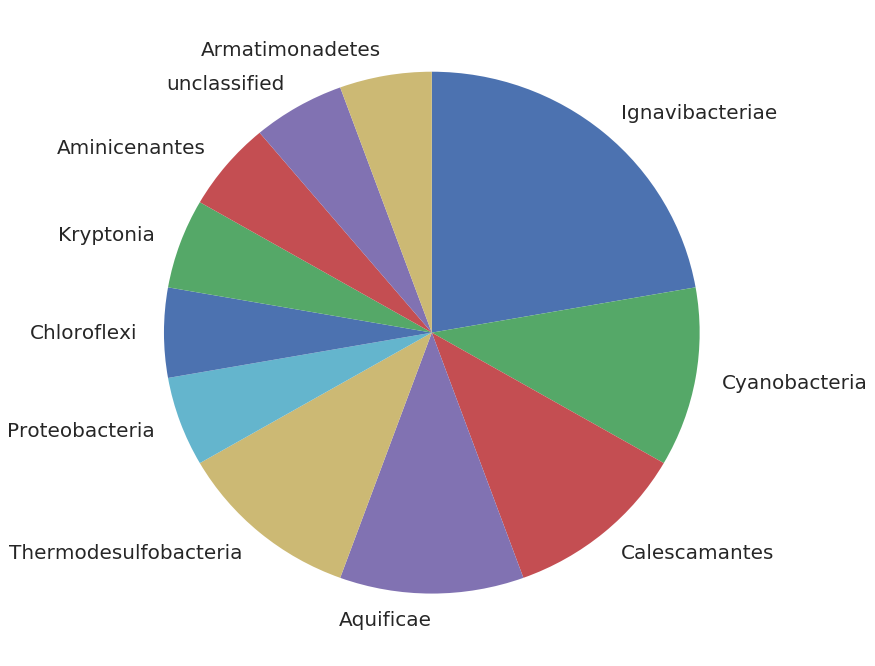

In [332]:
"""lookup_obsidian['Phylum '].value_counts().plot(kind='pie')
plt.show()"""
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)
lookup_obsidian[lookup_obsidian['Obsidian Bins '].str.contains('Obs5')]['Phylum '].value_counts().plot(kind='pie',startangle=90,counterclock=False)
plt.ylabel('')
plt.show()
f.savefig('writeup/figure1/65Cpie.pdf')

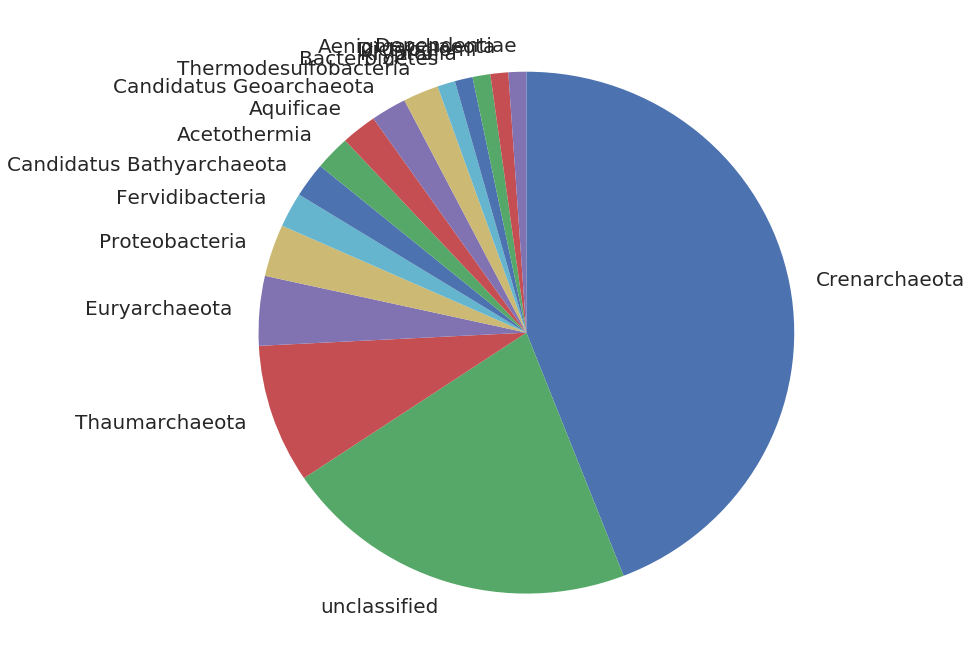

In [333]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)
lookup_obsidian[~lookup_obsidian['Obsidian Bins '].str.contains('Obs5')]['Phylum '].value_counts().plot(kind='pie',startangle=90,counterclock=False)
plt.ylabel('')
plt.show()
f.savefig('writeup/figure1/79Cpie.pdf')

In [229]:
# get the filenames of FASTA files (and contigs) to rename 
mypath = 'fasta/Obsidian3/'
#files_to_rename = ['Obsidian3_minimetagenomics_24.fasta','Obsidian3_minimetagenomics_25.fasta']
files_to_rename = ['Obsidian3_minimetagenomics_30.fasta']

newpath = mypath+'renamed_contigs/'
k = 24
for file in files_to_rename:
    input_file = mypath+file #input_file = 'fasta/checkm/max5pcont_min10pcomp/good_genomes/M50.fasta'
    output_file = file[0:-6]+'.fna'
    """if k==24:
        output_file = file[0:-6]+'.fna'
    else:
        output_file = file[0:-6]+'.fna'
    k+=1"""
    
    # get the contig names, make a new name based on the genome new name specified in 
    # the dataframe made directly above 
    sequences = dict( (s.name, s) for s in HTSeq.FastaReader(input_file) )
    sq = pd.DataFrame(index=sequences.keys())
    for contig in range(0,len(sq)):
        if contig<10:
            sq.loc[sq.index[contig],'new'] = file[0:-6]+'|'+file[0:-6]+'_contig_00'+str(contig) 
        elif contig<100:
            sq.loc[sq.index[contig],'new'] = file[0:-6]+'|'+file[0:-6]+'_contig_0'+str(contig) 
        elif contig<1000:
            sq.loc[sq.index[contig],'new'] = file[0:-6]+'|'+file[0:-6]+'_contig_'+str(contig) 
    
    #this is for record keeping 
    conversion_file = newpath+output_file+'.txt'
    sq['old_genome_name'] = file
    sq.to_csv(conversion_file,sep='\t') 
    
    #rename the contigs and write to output_file 
    with open(newpath+output_file, 'w') as out_file:
        for s in HTSeq.FastaReader( input_file ):
            newname = sq.loc[s.name,'new']
            s.name = newname # change the name of a contig header here
            s.write_to_fasta_file(out_file)
        out_file.close()
    
    


In [303]:
lookup_obsidian['metaPerc']=''
for oldname in lookup_obsidian['old_name']:
    idx = lookup_obsidian[lookup_obsidian['old_name']==oldname].index[0]
    lookup_obsidian.loc[idx,'metaPerc'] = alt5.loc[oldname,'metaPerc']

In [299]:
alt5['metaPerc'] = ''
for name in alt5[alt5.index.str.contains('M')]['clustsum']:
    if (len(name)>25):
        alt5.loc[alt5[alt5['clustsum']==name].index[0],'metaPerc'] = 2/3
    elif (len(name)<25) & ('mini' in name):
        alt5.loc[alt5[alt5['clustsum']==name].index[0],'metaPerc'] = 1/2
    else:
        alt5.loc[alt5[alt5['clustsum']==name].index[0],'metaPerc'] = 1
for name in alt5[~alt5.index.str.contains('M')].index:
    if 'mini' in name:
        alt5.loc[alt5[alt5.index==name].index[0],'metaPerc'] = 0
    else:
        alt5.loc[alt5[alt5.index==name].index[0],'metaPerc'] = 1
alt5.groupby('metaPerc').count()

,domain,phylum,species,assembly,orig doms,orig phyl,clustsum,sample,length
metaPerc,,,,,,,,,
0.000000,53,53,53,53,0,0,0,53,53
0.500000,7,7,7,7,7,7,7,7,7
0.666667,23,23,23,23,23,23,23,23,23
1.000000,104,104,104,104,54,54,54,104,104


In [288]:
len('Obs2_mini_8Obs2_mega_13')#Obs2_meta_6')


23

In [315]:
lookup_obsidian[lookup_obsidian['metaPerc']==0]['Domain'].value_counts()
metaperc = pd.DataFrame(index=[0,1/2,2/3,1],columns=['Arch','Bact','Archr','Bactr'])
metaperc.loc[0,'Arch']=6;metaperc.loc[0,'Bact']=18
metaperc.loc[1,'Arch']=47;metaperc.loc[1,'Bact']=7
metaperc.loc[2/3,'Arch']=12;metaperc.loc[2/3,'Bact']=5
metaperc.loc[1/2,'Arch']=3;metaperc.loc[1/2,'Bact']=1
metaperc['Archr'] = metaperc['Arch']/(metaperc['Arch']+metaperc['Bact'])
metaperc['Bactr'] = metaperc['Bact']/(metaperc['Arch']+metaperc['Bact'])
metaperc

,Arch,Bact,Archr,Bactr
0.000000,6,18,0.25,0.75
0.500000,3,1,0.75,0.25
0.666667,12,5,0.705882,0.294118
1.000000,47,7,0.87037,0.12963


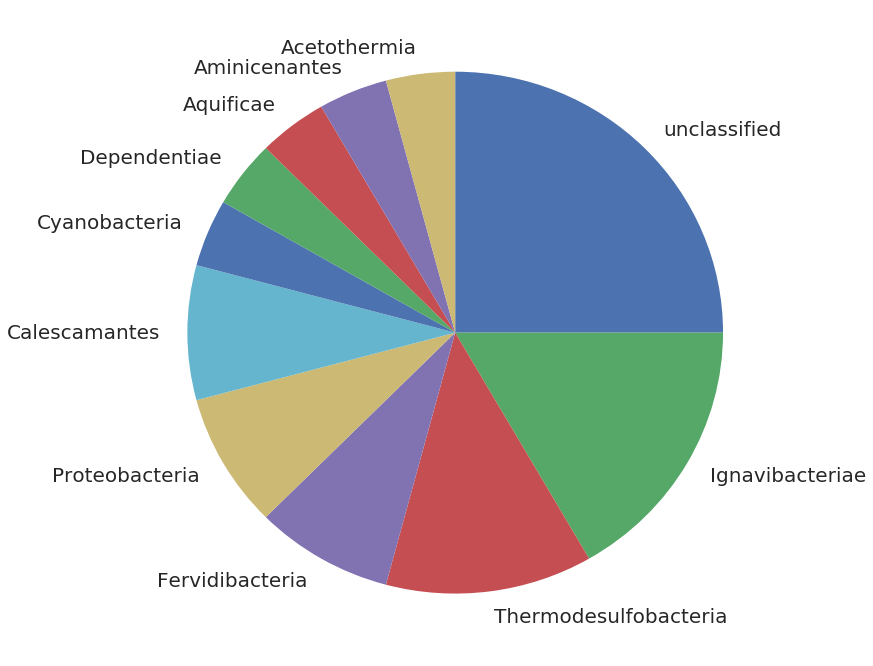

In [432]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)
lookup_obsidian[lookup_obsidian['metaPerc']==0]['Phylum '].value_counts().plot(kind='pie',startangle=90,counterclock=False)
plt.ylabel('')
plt.show()
f.savefig('writeup/figure1/minimetaPhyla.pdf')


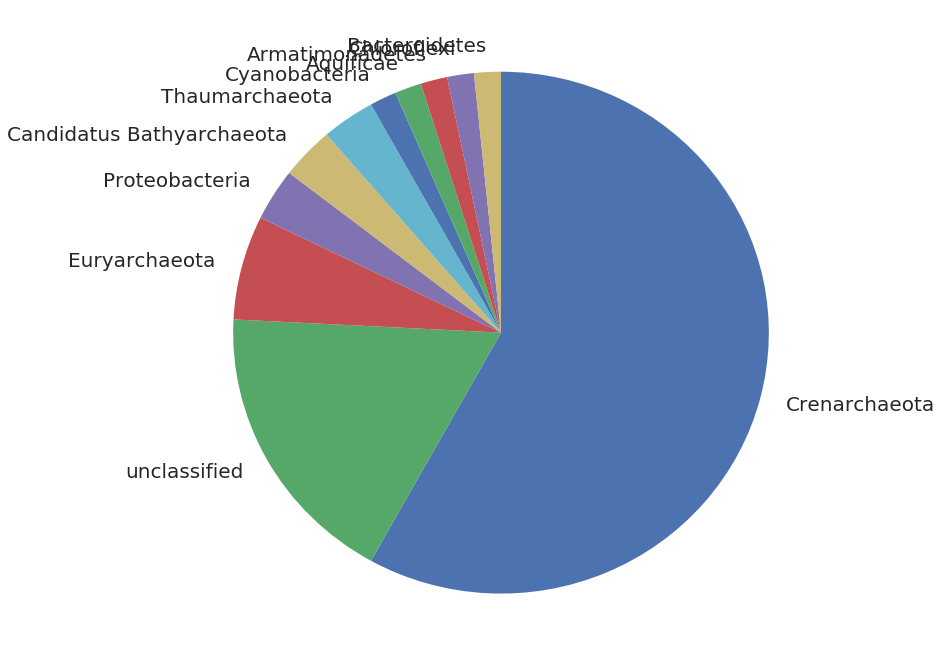

In [431]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)
lookup_obsidian[lookup_obsidian['metaPerc']==1]['Phylum '].value_counts().plot(kind='pie',startangle=90,counterclock=False)
plt.ylabel('')
plt.show()
f.savefig('writeup/figure1/shotgunPhyla.pdf')

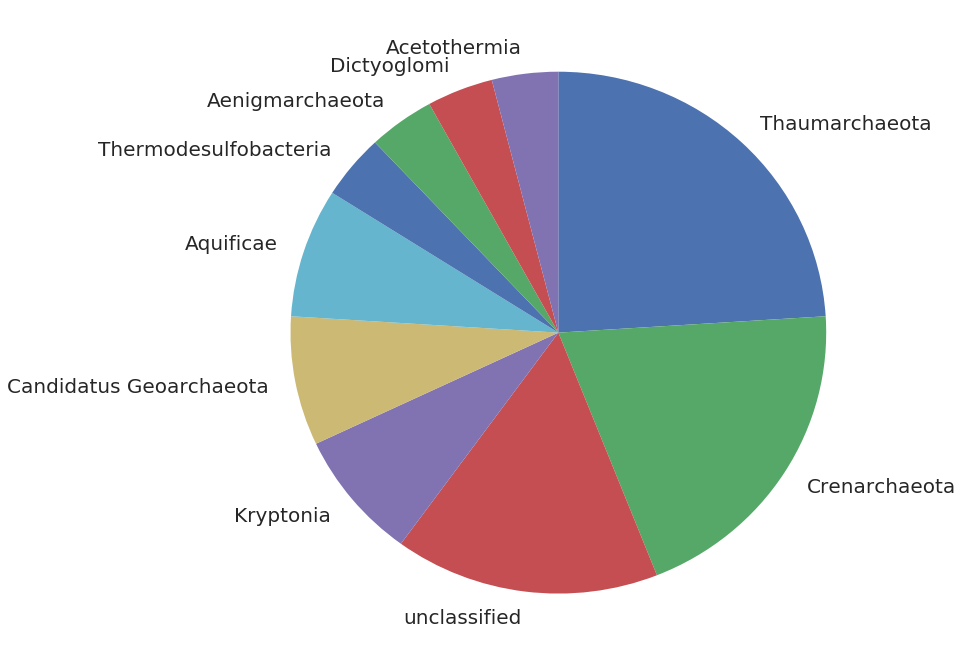

In [430]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)
lookup_obsidian[(lookup_obsidian['metaPerc']<1)&(lookup_obsidian['metaPerc']>0)]['Phylum '].value_counts().plot(kind='pie',startangle=90,counterclock=False)
plt.ylabel('')
plt.show()
f.savefig('writeup/figure1/mixedPhyla.pdf')

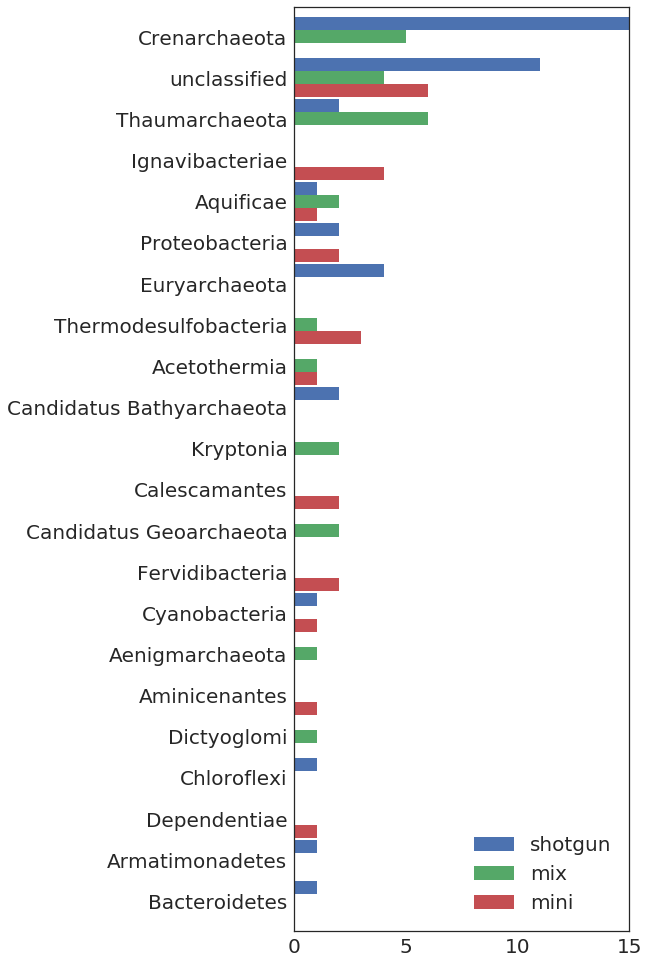

In [460]:
lookup_obsidian[lookup_obsidian['old_name']=='Obs2_mega_25']
lookup_obsidian[lookup_obsidian['metaPerc']=='']
lookup_obsidian[lookup_obsidian['metaPerc']==1]['Phylum '].value_counts()
countdf = pd.DataFrame(index=lookup_obsidian['Phylum '].value_counts().index,columns=['shotgun','mix','mini']).fillna(0)
countdf.loc[lookup_obsidian[lookup_obsidian['metaPerc']==1]['Phylum '].value_counts().index,'shotgun']= lookup_obsidian[lookup_obsidian['metaPerc']==1]['Phylum '].value_counts().values
countdf.loc[lookup_obsidian[lookup_obsidian['metaPerc']==0]['Phylum '].value_counts().index,'mini']= lookup_obsidian[lookup_obsidian['metaPerc']==0]['Phylum '].value_counts().values
countdf.loc[lookup_obsidian[(lookup_obsidian['metaPerc']<1)&(lookup_obsidian['metaPerc']>0)]['Phylum '].value_counts().index,'mix']= lookup_obsidian[(lookup_obsidian['metaPerc']<1)&(lookup_obsidian['metaPerc']>0)]['Phylum '].value_counts().values

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(17)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
countdf.plot.barh(ax=ax1,width=0.95)
plt.xlim(0,15)
plt.gca().invert_yaxis()
plt.show()

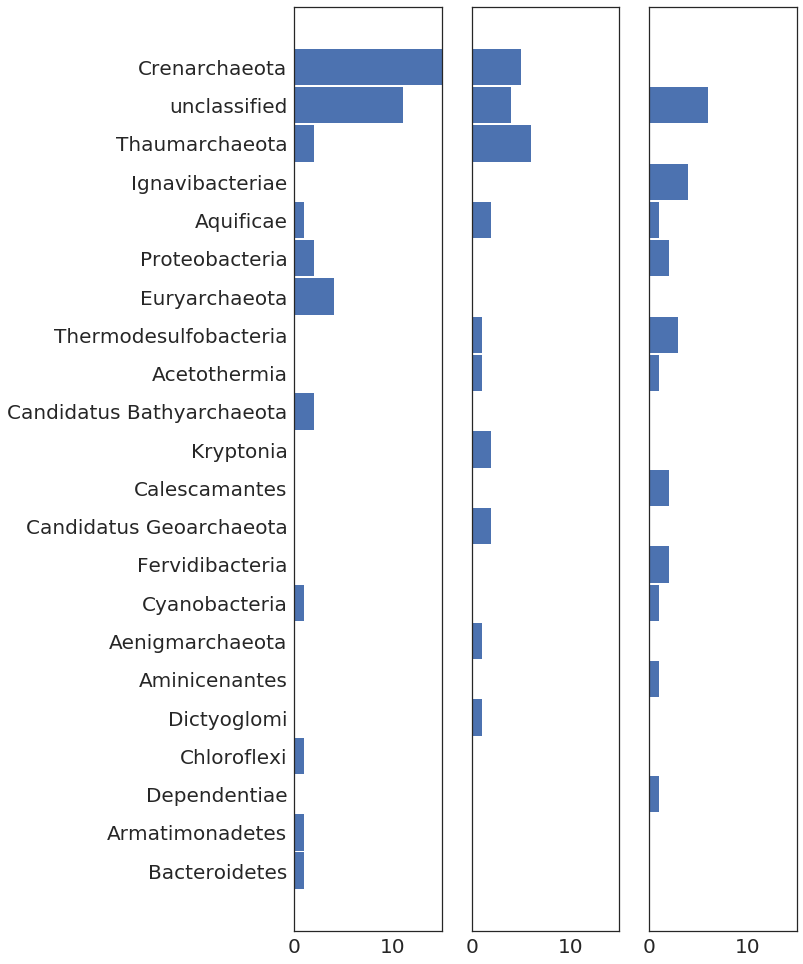

In [476]:
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(17)
gs = gridspec.GridSpec(1,3)

ax1 = f.add_subplot(gs[0,0])
plt.barh(range(0,len(countdf)),countdf['shotgun'],height=0.95)
plt.xlim(0,15)
#ax1.set_yticklabels(countdf.index)
plt.yticks(range(0,len(countdf)),countdf.index)
plt.gca().invert_yaxis()

ax2 = f.add_subplot(gs[0,1])
plt.barh(range(0,len(countdf)),countdf['mix'],height=0.95)
plt.xlim(0,15)
#ax1.set_yticklabels(countdf.index)
plt.yticks([])
plt.gca().invert_yaxis()

ax3 = f.add_subplot(gs[0,2])
plt.barh(range(0,len(countdf)),countdf['mini'],height=0.95)
plt.xlim(0,15)
#ax1.set_yticklabels(countdf.index)
plt.yticks([])
plt.gca().invert_yaxis()

plt.show()


In [427]:
#lookup_obsidian[(lookup_obsidian['metaPerc']<1)&(lookup_obsidian['metaPerc']>0)]
lookup_obsidian[lookup_obsidian['metaPerc']=='']
#lookup_obsidian['metaPerc'].value_counts()
lookup_obsidian[lookup_obsidian['old_name']=='Obs2_mega_25']

for double in lookup_obsidian['old_name'].unique():
    temp = lookup_obsidian[lookup_obsidian['old_name']==double]
    if len(temp)>1:
        for i in range(1,len(temp)):
            lookup_obsidian.loc[temp.index[i],'metaPerc'] = temp.loc[temp.index[i-1],'metaPerc']
        
lookup_obsidian[lookup_obsidian['metaPerc']=='']     



,Obsidian Bins,Nearest neighbor ID,Domain,Phylum,Class,Order,Family,Genus,Species,Classification up to,...,GC,GC std,Genome size,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,final_list,old_name,metaPerc


In [429]:
lookup_obsidian[lookup_obsidian['old_name']=='Obs4_mega_6']
#lookup_obsidian[lookup_obsidian['Obsidian Bins '].str.contains('061')]


,Obsidian Bins,Nearest neighbor ID,Domain,Phylum,Class,Order,Family,Genus,Species,Classification up to,...,GC,GC std,Genome size,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,final_list,old_name,metaPerc
70,Obs4_genome_070,IMG2508501049,Archaea,Crenarchaeota,Thermoprotei,Sulfolobales,unclassified,unclassified,unclassified,Order,...,0.48,0.02,811299,42887,11268.04,12560,0,Obsidian4_genome_121_1,Obs4_mega_6,1
71,Obs4_genome_071,IMG2514885039,Archaea,Crenarchaeota,Thermoprotei,Sulfolobales,unclassified,unclassified,unclassified,Order,...,0.48,0.02,1679185,115532,17675.63,21411,0,Obsidian4_genome_121_2,Obs4_mega_6,1
72,Obs4_genome_072,IMG2513237177,Archaea,Crenarchaeota,Thermoprotei,Sulfolobales,unclassified,unclassified,unclassified,Order,...,0.50,0.03,1553120,44312,11677.58,13832,0,Obsidian4_genome_121_3,Obs4_mega_6,1


In [402]:
alt5[alt5.index=='M49']


,domain,phylum,species,assembly,orig doms,orig phyl,clustsum,sample,length,metaPerc
M49,Unassigned,Unassigned,Unassigned,megameta,UnassignedUnassigned,UnassignedUnassigned,Obs4_mega_7Obs4_meta_6,Obs4,4132896.0,1


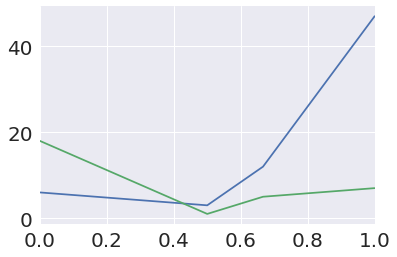

In [320]:
metaperc['Arch'].plot()
metaperc['Bact'].plot()
plt.show()

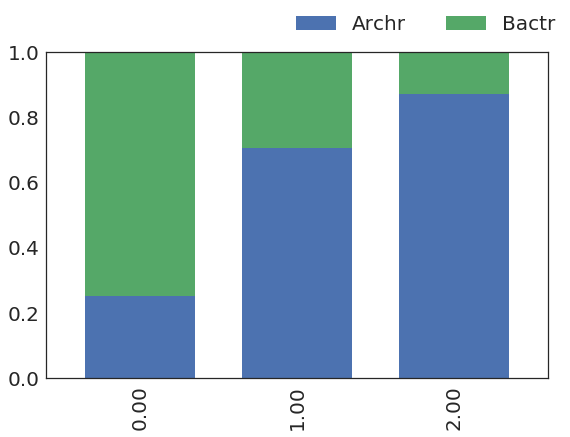

In [362]:
sns.set_style('white')# {darkgrid, whitegrid, dark, white, ticks}
from matplotlib.ticker import FormatStrFormatter
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(6)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
metaperc.loc[[0,2/3,1],['Archr','Bactr']].plot.bar(stacked=True,ax=ax1,width=.7)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(bbox_to_anchor=(1.05, 1),loc=4,ncol=2)

plt.ylim(0,1)
plt.show()
f.savefig('writeup/figure1/barArBac.pdf')

In [409]:
# new phylum - comparative metabolic analysis
NAG2_OSP = pd.read_csv('MAGs/NewPhylum/2524023200_NAG2_mk4-r01 (from OSP_D).info.csv')
NAG2_BED = pd.read_csv('MAGs/NewPhylum/2524023239_NAG2_ff85-r04 (from BED).info.csv')
NAG2_OSP_modules = NAG2_OSP[NAG2_OSP['Cluster Information'].fillna('x').str.contains('M00')]['Cluster Information'].str[0:6].unique()
NAG2_BED_modules = NAG2_BED[NAG2_BED['Cluster Information'].fillna('x').str.contains('M00')]['Cluster Information'].str[0:6].unique()
len(NAG2_OSP_modules)
len(NAG2_BED_modules)

169

In [410]:
NAG2_BED_modules

array(['M00359', 'M00360', 'M00177', 'M00179', 'M00342', 'M00343',
       'M00027', 'M00570', 'M00120', 'M00053', 'M00003', 'M00002',
       'M00001', 'M00055', 'M00173', 'M00620', 'M00614', 'M00011',
       'M00374', 'M00009', 'M00582', 'M00390', 'M00391', 'M00362',
       'M00178', 'M00184', 'M00052', 'M00050', 'M00049', 'M00121',
       'M00365', 'M00364', 'M00425', 'M00401', 'M00335', 'M00095',
       'M00029', 'M00361', 'M00632', 'M00376', 'M00613', 'M00346',
       'M00140', 'M00141', 'M00532', 'M00020', 'M00010', 'M00740',
       'M00012', 'M00670', 'M00254', 'M00210', 'M00669', 'M00115',
       'M00018', 'M00017', 'M00019', 'M00432', 'M00535', 'M00119',
       'M00036', 'M00144', 'M00116', 'M00117', 'M00307', 'M00005',
       'M00288', 'M00087', 'M00113', 'M00423', 'M00165', 'M00167',
       'M00612', 'M00611', 'M00344', 'M00166', 'M00394', 'M00016',
       'M00525', 'M00527', 'M00526', 'M00239', 'M00545', 'M00133',
       'M00026', 'M00357', 'M00617', 'M00045', 'M00032', 'M000